In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [30]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
model = llm.bind_tools(tools)

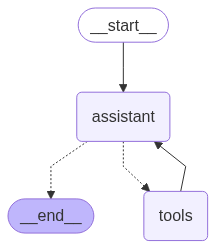

In [31]:
from IPython.display import display, Image

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

system_message = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState) -> MessagesState:
    return {"messages": model.invoke([system_message] + state["messages"])}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]} # HumanMessage only work why I dont know [] is not required

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_5GL2bS7Eio8bvHjKETDd70yr)
 Call ID: call_5GL2bS7Eio8bvHjKETDd70yr
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [33]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5GL2bS7Eio8bvHjKETDd70yr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbU1NICV8uGXXXuzHs0MFBI1kWidK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b28807c8-d167-4ddd-a182-5a80240dad6d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_5GL2bS7

In [34]:
all_states = [s for s in graph.get_state_history(thread)]
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5GL2bS7Eio8bvHjKETDd70yr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbU1NICV8uGXXXuzHs0MFBI1kWidK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b28807c8-d167-4ddd-a182-5a80240dad6d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_5GL2bS

In [35]:
len(all_states)

5

In [36]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-26T15:27:13.755598+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-62fb-63d6-bfff-10ddbe2e3e77'}}, tasks=(PregelTask(id='154d2a78-804a-e0bd-313d-090a3e4ba4b8', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5GL2bS7Eio8bvHjKETDd70yr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_to

In [37]:
to_replay = all_states[-2]

In [38]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-26T15:27:13.755598+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-62fb-63d6-bfff-10ddbe2e3e77'}}, tasks=(PregelTask(id='154d2a78-804a-e0bd-313d-090a3e4ba4b8', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5GL2bS7Eio8bvHjKETDd70yr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_to

In [39]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]}

In [40]:
to_replay.next

('assistant',)

In [41]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}}

In [43]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_9JABIsxHpALGGtqX4Puh45Z0)
 Call ID: call_9JABIsxHpALGGtqX4Puh45Z0
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [44]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]

In [45]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}}

In [46]:
fork_config = graph.update_state(to_fork.config, {"messages": [HumanMessage(content="Multiply 3 and 4", id=to_fork.values["messages"][0].id)]})

In [47]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03a48a-7078-6318-8001-42ecd4de5067'}}

In [53]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a48a-7078-6318-8001-42ecd4de5067'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}, created_at='2025-05-26T15:46:56.282908+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}}, tasks=(PregelTask(id='e3d359a3-aa34-cfd6-b863-cbc29214a185', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 S

In [54]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a48a-7078-6318-8001-42ecd4de5067'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 3 and 4', additional_kwargs={}, response_metadata={}, id='5864e299-9438-4881-8e56-e895392bc5cc')]}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}, created_at='2025-05-26T15:46:56.282908+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a45e-6302-6a10-8000-345b8a7dcca7'}}, tasks=(PregelTask(id='e3d359a3-aa34-cfd6-b863-cbc29214a185', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [55]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ze5qsx01C4YhYEbLQfUIFpLo)
 Call ID: call_ze5qsx01C4YhYEbLQfUIFpLo
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The result of multiplying 3 and 4 is 12.


In [56]:
for event in graph.stream({"messages": HumanMessage(content="What was my first message ?")}, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What was my first message ?
================================== Ai Message ==================================

Your first message was "Multiply 3 and 4".


In [86]:
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

In [87]:
assistants = await client.assistants.search()
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2025-05-25T13:10:51.548011+00:00',
  'updated_at': '2025-05-25T13:10:51.548011+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-05-25T13:10:51.542586+00:00',
  'updated_at': '2025-05-25T13:10:51.542586+00:00',
  'version': 1,
  'description': None}]

In [88]:
initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
thread = await client.threads.create()

async for chunk in client.runs.stream(thread["thread_id"], assistant_id="agent", input=initial_input, stream_mode="updates"):
    if chunk.data:
        assistant_node = chunk.data.get("assistant", {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assistant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assistant_node[-1])
        if tool_node:
            print("-" * 20+"Tool Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_oVYy1SsKAsywGhoOxtO5h1Br', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BbVMX2gvagPTsDUabAsWnj79ukRKJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--88924948-461d-47a5-aa98-79efdda01b87-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_oVYy1SsKAsywGhoOxtO5h1Br', 'type': 'tool_call'}], 'invalid_tool_

In [89]:
states = await client.threads.get_history(thread_id=thread["thread_id"])

In [90]:
states

[{'values': {'messages': [{'content': 'Multiply 2 and 3',
     'additional_kwargs': {},
     'response_metadata': {},
     'type': 'human',
     'name': None,
     'id': '7b6498f0-41aa-446d-abcd-7d84af492bf8',
     'example': False},
    {'content': '',
     'additional_kwargs': {'tool_calls': [{'id': 'call_oVYy1SsKAsywGhoOxtO5h1Br',
        'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
        'type': 'function'}],
      'refusal': None},
     'response_metadata': {'token_usage': {'completion_tokens': 17,
       'prompt_tokens': 134,
       'total_tokens': 151,
       'completion_tokens_details': {'accepted_prediction_tokens': 0,
        'audio_tokens': 0,
        'reasoning_tokens': 0,
        'rejected_prediction_tokens': 0},
       'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
      'model_name': 'gpt-4o-2024-08-06',
      'system_fingerprint': 'fp_07871e2ad8',
      'id': 'chatcmpl-BbVMX2gvagPTsDUabAsWnj79ukRKJ',
      'service_tier': 'defaul

In [91]:
to_replay = states[-2]

In [92]:
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '7b6498f0-41aa-446d-abcd-7d84af492bf8',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '286ff6e0-9cfb-c762-f2ad-4f85bc6ac1be',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_oVYy1SsKAsywGhoOxtO5h1Br',
         'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
         'type': 'function'}],
       'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 17,
        'prompt_tokens': 134,
        'total_tokens': 151,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'audio_tokens': 0,
         'reasoning_tokens': 0,
         'rejected_predictio

In [93]:
async for chunk in client.runs.stream(thread_id=thread['thread_id'], assistant_id="agent", input=None, checkpoint_id=to_replay["checkpoint_id"], stream_mode="values"):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1f03a51e-9ea8-6e65-b020-2f8fc3dff25b', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '7b6498f0-41aa-446d-abcd-7d84af492bf8', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '7b6498f0-41aa-446d-abcd-7d84af492bf8', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_4Io2fEfiFSKlxzVw8U8rF4sa', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_predict

In [94]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_TfHGJyPwZhNjs7WOiB8093x0', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BbVMgPsgeKeHYIEQ8HqWz8zp8WOVa', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--9f3443ce-d012-44d1-a4e9-2a1e076ef84b-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_TfHGJyPwZhNjs7WOiB8093x0', 'type': 'tool_call'}], 'invalid_tool_

In [95]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_elvagg9e1N6JSvEEPk2LKwMS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BbVMjGNz3KqU0tFkTfaOvhIAvIOd2', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--beb808a0-5fff-4acb-8958-269d31e09f04-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_elvagg9e1N6JSvEEPk2LKwMS', 'type': 'tool_call'}], 'invalid_tool_

In [96]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '43405952-3393-4fe4-b98c-b6668ab9c87f',
   'example': False}]}

In [97]:
to_fork['values']['messages'][0]['id']

'43405952-3393-4fe4-b98c-b6668ab9c87f'

In [98]:
to_fork['next']

['assistant']

In [99]:
to_fork['checkpoint_id']

'1f03a51e-fd61-6b66-8000-dde82f7b4d65'

In [109]:
fork_input = {"messages": HumanMessage(content="Multiply 3 and 4", id=to_fork['values']['messages'][0]['id'])}

In [110]:
fork_config = await client.threads.update_state(thread['thread_id'], fork_input, checkpoint_id=to_fork['checkpoint_id'])

In [111]:
fork_config

{'checkpoint': {'thread_id': '6d238a34-43e0-4c6d-9f7e-1a14d82e1857',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03a52e-462f-650e-8001-a02ce94de455'},
 'configurable': {'thread_id': '6d238a34-43e0-4c6d-9f7e-1a14d82e1857',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03a52e-462f-650e-8001-a02ce94de455'},
 'checkpoint_id': '1f03a52e-462f-650e-8001-a02ce94de455'}

In [112]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 4',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '43405952-3393-4fe4-b98c-b6668ab9c87f',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'd4a9db52-4253-957b-a456-350bbbbd68b5',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'graph_id': 'agent',
  'thread_id': '6d238a34-43e0-4c6d-9f7e-1a14d82e1857',
  'checkpoint_id': '1f03a51e-fd61-6b66-8000-dde82f7b4d65',
  'checkpoint_ns': '',
  'user-agent': 'langgraph-sdk-py/0.1.70',
  'x-request-id': '595d3152-7cde-499c-b756-318dc1e6df30',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '595d3152-7cde-499c-b756-318dc1e6df30',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'creat

In [115]:
async for chunk in client.runs.stream(thread_id=thread['thread_id'], assistant_id="agent", input=fork_input, checkpoint_id=to_fork['checkpoint_id'], stream_mode="updates"):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_751kOfXPdhc4l1PihF0yTgc7', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BbVUGcavZcOSJi6WzRm2Z2oiVoXPF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--a4e0beba-bf39-4785-ac6f-208b8f51aa26-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 4}, 'id': 'call_751kOfXPdhc4l1PihF0yTgc7', 'type': 'tool_call'}], 'invalid_tool_